# **Imports**

In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import math  
import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from functools import reduce

%matplotlib inline

# Consts
MNIST_BATCH_SIZE = 128
NUM_CLASSES = 10

# **Import RAdam**

In [2]:
from google.colab import files
src = list(files.upload().values())[0]
open('mylib1.py','wb').write(src)
import mylib1

Saving gitradam.py to gitradam.py


# **Image Helper Class**

In [0]:
class Image(object):
  def __init__(self, path):
    self.path = path

    self.rgb_image = None
    self.bgr_image = None
    self.gray_image = None


  def read_image(self, return_image = False):
    self.rgb_image = plt.imread(self.path)
    if return_image:
      return self.rgb_image


  def bgr(self, return_image = False):
    self.bgr_image = np.flip(plt.imread(self.path), 2)
    if return_image:
      return self.bgr_image


  def gray(self, return_image = False):
    self.gray_image = cv2.cvtColor(plt.imread(self.path), cv2.COLOR_RGB2GRAY)
    if return_image:
      return self.gray_imagezoom_img


  @staticmethod
  def show(image, title = 'image'):
    if len(image.shape) == 3:
      plt.imshow(image)
    else:
      plt.imshow(image, cmap = 'gray')

    plt.title(title)


  @staticmethod
  def show_all(image_list, title_list):
    assert len(image_list) == len(title_list), "Incompatible lengths of lists!"
    N = len(image_list)
    plt.figure(figsize=[20, 20])

    for i in range(N):
      plt.subplot(1, N, i + 1)
      Image.show(image_list[i], title_list[i])
    
    plt.show()

# **MNIST Train Dataset and Dataloader**

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!



/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


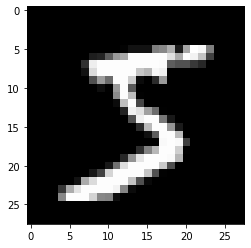

In [4]:
train_set = torchvision.datasets.MNIST(root='', train=True, download=True, transform=transforms.ToTensor())
test_set = torchvision.datasets.MNIST(root='', train=False, download=True, transform=transforms.ToTensor())

num_classes = len(train_set)

img = np.asarray(train_set[0][0][0])
plt.imshow(img, cmap='gray')

In [0]:
class MnistDataset(Dataset):
  def __init__(self, train_set, transforms=None, preprocessing=None):
    super(MnistDataset, self).__init__()
    self.x_train = train_set.data[:, np.newaxis, :, :].float()
    self.y_train = train_set.targets
    self.transforms = transforms
    self.preprocessing = preprocessing


  def __getitem__(self, idx):
    x = self.x_train[idx]
    y = self.y_train[idx]

    if self.transforms:
      x = self.transforms(image = x.numpy())
      x = x['image']

    return x, y


  def __len__(self):
    return len(self.x_train)

In [0]:
def batch_norm(x_batch):
  # Normalizes batch data and makes it ready for the model input

  std, mean = torch.std_mean(x_batch.float())

  for i in range(len(x_batch)):
    x_batch[i] = ((x_batch[i] - mean) / (std + 1e-8))

  return x_batch[:, np.newaxis, :, :].float()

In [0]:
# Creates MNIST Dataset
mnist_train_dataset = MnistDataset(train_set)

# Creates MNIST Dataloader by the instance of MNIST Dataset above
mnist_train_dataloader = DataLoader(mnist_train_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True, num_workers=4)

# **Focal Loss Function**

In [0]:
def focal_loss(y_lbl, y_pred, gamma=2):
  # y_lbl is a tensor which includes the the existing probabilities' labels [0, 0, ... , 1, 0, ..., n]
  # y_pred is a tensor which includes a model probabilities' predictions
  # y_pred should be passed to this function AFTER any probability manupulation, for instance, a softmax manipulation
  assert len(y_lbl) == len(y_pred), "Incompatible lengths: len(y_lbl)=" + str(len(y_lbl)) + ", len(y_pred)=" + str(len(y_pred))

  s = 0
  for i in range(len(y_lbl)):
    if y_lbl[i] == 1:
      p = y_pred[i]
    else:
      p = 1 - y_pred[i]
    s -= (((1 - p) ** gamma) * math.log(p))

  return s / len(y_lbl)

In [0]:
# Focal lost for a batch of images
def batch_focal_loss(preds, y, gamma=2):
  assert len(preds) == len(y), "Incompatible lengths: len(preds)=" + str(len(preds)) + ", len(y)=" + str(len(y))

  y_temp = torch.zeros([len(y), NUM_CLASSES], dtype=torch.float32)
  for i in range(len(y)):
    y_temp[i][y[i]] = 1 

  return reduce(lambda x, y: x + y, [focal_loss(lbl, pred) for lbl, pred in zip(y_temp, preds)]) / len(y)

In [12]:
# Good prediction example

y_pred = [0.1, 0.2, 0.9, 0.15, 0.03, 0.11, 0.001, 0.02, 0.28, 0.04]
y_lbl = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
print(focal_loss(y_lbl, y_pred))


# Bad prefiction examples

y_lbl[2], y_lbl[6] = 0, 1
print(focal_loss(y_lbl, y_pred))

y_pred = [0.5, 0.3, 0.9, 0.15, 0.8, 0.75, 0.2, 0.1, 0.6, 0.5]
y_lbl = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
print(focal_loss(y_lbl, y_pred))

0.0041955216868125485
0.8799942212215676
0.626114010941354


# **LeNet Model**

In [0]:
class Convolution_Model(nn.Module):
  def __init__(self):
    super(Convolution_Model, self).__init__()
    
    self.conv1 = nn.Conv2d(1, 7, 5)
    self.conv2 = nn.Conv2d(7, 16, 5)

    self.fc1 = nn.Linear(in_features=16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 3)

    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 3)

    x = x.view(x.shape[0], -1)
    x = self.fc1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = F.relu(x)

    x = self.fc3(x)

    x = F.softmax(x, dim=1)
    return x

In [0]:
def batch_accuracy(y, pred):
  # Calculates accuracy for a given batch of data
  
  assert len(y) == len(pred), "Incompatible lengths: len(y)=" + str(len(y)) + ", len(y_pred)=" + str(len(pred))

  true_preds = 0
  for i in range(len(y)):
    if torch.max(pred) == pred[i][y[i]]:
      true_preds += 1
  
  return true_preds / len(y)

In [0]:
# Training the model 
def train(model, optimizer, dataloader, num_epochs=10, loss=nn.CrossEntropyLoss()):
  convergence_lst = list()
  accuracy_lst = list()

  for epoch in range(num_epochs):
    i = 0
    print("********** epoch no' " + str(epoch + 1) + " from " + str(num_epochs) + " **********")

    for data in dataloader:
      x, y = data

      # zero the gradients after updating
      optimizer.zero_grad()

      # y prediction = forward pass with our model
      y_pred = model(x)

      # loss
      l = loss(y_pred, y)
      convergence_lst.append(l)
      ac = batch_accuracy(y, y_pred)
      accuracy_lst.append(ac)     

      # calculate gradients = backward pass
      l.backward()

      # update weights
      optimizer.step()

      i += 1
      if i % 100 == 0:
        print(str(i) + " from " + str(len(dataloader)) + ": current batch accuracy=" + str(ac) + " loss=" + str(l))

  return convergence_lst, accuracy_lst

In [55]:
# Define the model
model = Convolution_Model()

# Optimizers
adam_optim = torch.optim.Adam(model.parameters())
radam_optim = mylib1.RAdam(model.parameters())
sgd_optim = torch.optim.SGD(model.parameters(), lr=0.01)

convergence_lst, accuracy_lst = train(model, radam_optim, mnist_train_dataloader, loss=batch_focal_loss)

********** epoch no' 1 from 10 **********
100 from 469: current batch accuracy=0.0078125 loss=tensor(1.9848, grad_fn=<NllLossBackward>)
200 from 469: current batch accuracy=0.1015625 loss=tensor(1.7547, grad_fn=<NllLossBackward>)
300 from 469: current batch accuracy=0.28125 loss=tensor(1.7230, grad_fn=<NllLossBackward>)
400 from 469: current batch accuracy=0.34375 loss=tensor(1.6357, grad_fn=<NllLossBackward>)
********** epoch no' 2 from 10 **********
100 from 469: current batch accuracy=0.6015625 loss=tensor(1.4987, grad_fn=<NllLossBackward>)
200 from 469: current batch accuracy=0.6484375 loss=tensor(1.5255, grad_fn=<NllLossBackward>)
300 from 469: current batch accuracy=0.7265625 loss=tensor(1.5304, grad_fn=<NllLossBackward>)
400 from 469: current batch accuracy=0.703125 loss=tensor(1.5157, grad_fn=<NllLossBackward>)
********** epoch no' 3 from 10 **********
100 from 469: current batch accuracy=0.84375 loss=tensor(1.4821, grad_fn=<NllLossBackward>)
200 from 469: current batch accurac

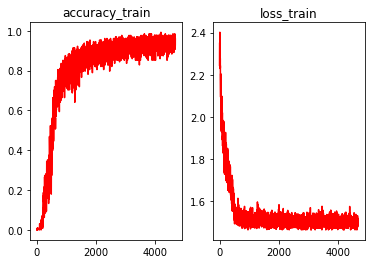

In [56]:
plt.figure()

plt.subplot(1, 2, 1)
plt.title("accuracy_train")
plt.plot(np.array(accuracy_lst), 'r')

plt.subplot(1, 2, 2)
plt.title("loss_train")
plt.plot(np.array(convergence_lst), 'r')

plt.show()

# **MNIST Test Dataset and Dataloader**

In [0]:
# Creates MNIST Dataset
mnist_test_dataset = MnistDataset(test_set)

# Creates MNIST Dataloader by the instance of MNIST Dataset above
mnist_test_dataloader = DataLoader(mnist_test_dataset, batch_size=MNIST_BATCH_SIZE, shuffle=True, num_workers=4)

# **Prediction Of Test Samples**

In [0]:
def predict(model, dataloader, pred_num, loss=nn.CrossEntropyLoss()):
  i = 0
  convergence_lst = list()
  accuracy_lst = list()
  confusion_mat = np.zeros((NUM_CLASSES, NUM_CLASSES))

  for data in dataloader:
    x, y = data

    # y prediction = forward pass with our model
    y_pred = model.forward(x)

    l = loss(y_pred, y)
    convergence_lst.append(l)
    ac = batch_accuracy(y, y_pred)
    accuracy_lst.append(ac)

    for j in range(len(y)):
      confusion_mat[y[j]][np.where(y_pred[j] == max(y_pred[j]))] += 1

    i += 1
    if i >= pred_num:
      break
    
  return confusion_mat, accuracy_lst, convergence_lst

In [0]:
confusion_mat, accuracy_vals, loss_vals = predict(model, mnist_test_dataloader, len(mnist_test_dataloader.dataset.y_train))

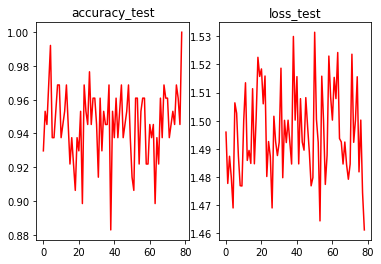

In [57]:
plt.figure()

plt.subplot(1, 2, 1)
plt.title("accuracy_test")
plt.plot(np.array(accuracy_vals), 'r')

plt.subplot(1, 2, 2)
plt.title("loss_test")
plt.plot(np.array(loss_vals), 'r')

plt.show()

In [0]:
def print_confusion_mat(confusion_mat):
  for i in range(confusion_mat.shape[0]):
    print()
    
    for j in range(confusion_mat.shape[1]):
      print(str(confusion_mat[i][j]), end="\t")

In [58]:
print_confusion_mat(confusion_mat)


971.0	0.0	2.0	0.0	1.0	2.0	2.0	1.0	0.0	1.0	
1.0	1122.0	1.0	3.0	0.0	3.0	0.0	4.0	1.0	0.0	
10.0	1.0	967.0	7.0	1.0	0.0	2.0	43.0	1.0	0.0	
1.0	0.0	6.0	985.0	0.0	7.0	0.0	8.0	1.0	2.0	
2.0	1.0	2.0	0.0	912.0	1.0	5.0	14.0	6.0	39.0	
3.0	1.0	0.0	9.0	0.0	876.0	1.0	1.0	0.0	1.0	
15.0	1.0	2.0	0.0	7.0	19.0	911.0	0.0	2.0	1.0	
0.0	3.0	5.0	2.0	0.0	0.0	0.0	1014.0	3.0	1.0	
5.0	0.0	6.0	8.0	1.0	9.0	1.0	2.0	927.0	15.0	
5.0	1.0	0.0	11.0	1.0	4.0	0.0	10.0	7.0	970.0	